In [1]:
import multiprocessing as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from brian2.only import *
import spatial

In [2]:
rng = np.random.default_rng()
set_device('cpp_standalone')
prefs.devices.cpp_standalone.openmp_threads = mp.cpu_count() - 2

In [3]:
N = 1000
inhibitory_ratio = .2

params = {
    # Population size
    'N': N,
    'N_exc': int((1-inhibitory_ratio) * N),
    'N_inh': int(inhibitory_ratio * N),

    # Membrane
    'v_rest': -60*mV,
    'v_reset': -74*mV,
    'v_threshold': -54*mV,
    
    'tau_mem': 30*ms,
    'refractory_exc': 3*ms,
    'refractory_inh': 2*ms,

    # Threshold adaptation - Exc
    'th_tau': 1*second,
    'th_ampl': 1*mV,

    # Short-term plasticity - Exc
    'tau_rec': 150*msecond,
    'U': 0.4,

    # Synapse dynamics
    'E_exc': 0*mV,
    'tau_ampa': 2*msecond,
    'E_inh': -100*mV,
    'tau_gaba': 4*msecond,
    
    # Stochasticity
    'tau_noise': 10*msecond,
    'vnoise_std': 0.5*mV,

    # Layout
    'r_dish': 4*mm,
    
    # Connectivity: Inh
    'r_inh': 1*mm,
    'outdeg_inh': 50,
    'w_inh_mean': np.log(1),
    'w_inh_sigma': 0.2,

    # Connectivity: Exc
    'r_exc': 2*mm,
    'outdeg_exc': 30,
    'w_exc_mean': np.log(1),
    'w_exc_sigma': 0.2,

    # Stimulus
    'N_stimuli': 10,
    'stim_distribution_radius': 2.5*mm,
    'neurons_per_stim': 10,
    'input_strength': 100,

    # Paradigm
    'settling_period': 1*second,
    'sequence_length': 10,
    'sequence_count': 10,
    'ISI': 500*ms,
}

In [4]:
def create_weights(params, rng):
    X, Y = spatial.generate_circle_locations(params['N'], params['r_dish'], rng)
    iPre_exc, iPost_exc, distance_exc = spatial.get_boxcar_connections(
        X[:params['N_exc']], Y[:params['N_exc']],
        X, Y,
        radius=params['r_exc'], outdegree=params['outdeg_exc'], rng=rng
    )
    iPre_inh, iPost_inh, distance_inh = spatial.get_boxcar_connections(
        X[params['N_exc']:], Y[params['N_exc']:],
        X, Y,
        radius=params['r_inh'], outdegree=params['outdeg_inh'], rng=rng
    )
    
    W_exc = rng.lognormal(params['w_exc_mean'], params['w_exc_sigma'], iPre_exc.shape)
    W_inh = rng.lognormal(params['w_inh_mean'], params['w_inh_sigma'], iPre_inh.shape)
    W = np.full((params['N'], params['N']), np.nan)
    W[iPre_exc, iPost_exc] = W_exc
    W[iPre_inh + params['N_exc'], iPost_inh] = W_inh

    D = np.full_like(W, np.nan)
    D[iPre_exc, iPost_exc] = distance_exc
    D[iPre_inh, iPost_inh] = distance_inh

    return X, Y, W, D

In [5]:
def create_excitatory(Net, X, Y, params, rng : np.random.Generator):
    excitatory_eqn = '''
        dv/dt = ((v_rest-v) + (E_exc-v)*g_exc + (E_inh-v)*g_inh) / tau_mem + vnoise_std*sqrt(2/tau_noise)*xi : volt (unless refractory)
        dg_exc/dt = -g_exc/tau_ampa : 1
        dg_inh/dt = -g_inh/tau_gaba : 1
        dth_adapt/dt = -th_adapt/th_tau : volt
        x : meter
        y : meter
    '''
    excitatory_threshold = 'v > v_threshold + th_adapt'
    excitatory_reset = '''
        v = v_reset
        th_adapt += th_ampl
    '''

    Exc = NeuronGroup(params['N_exc'], excitatory_eqn, threshold=excitatory_threshold, reset=excitatory_reset, refractory=params['refractory_exc'],
                    method='euler', namespace=params, name='Exc')
    Exc.x, Exc.y = X[:params['N_exc']], Y[:params['N_exc']]
    Exc.v = rng.uniform(params['v_reset']/volt, params['v_threshold']/volt, params['N_exc'])*volt
    Exc.th_adapt = 0
    Exc.g_exc, Exc.g_inh = 0, 0

    Net.add(Exc)
    return Exc

In [6]:
def create_inhibitory(Net, X, Y, params, rng : np.random.Generator):
    inhibitory_eqn = '''
        dv/dt = ((v_rest-v) + (E_exc-v)*g_exc + (E_inh-v)*g_inh) / tau_mem + vnoise_std*sqrt(2/tau_noise)*xi : volt (unless refractory)
        dg_exc/dt = -g_exc/tau_ampa : 1
        dg_inh/dt = -g_inh/tau_gaba : 1
        x : meter
        y : meter
    '''
    inhibitory_threshold = 'v > v_threshold'
    inhibitory_reset = 'v = v_reset'

    Inh = NeuronGroup(params['N_inh'], inhibitory_eqn, threshold=inhibitory_threshold, reset=inhibitory_reset, refractory=params['refractory_inh'],
                    method='euler', namespace=params, name='Inh')
    Inh.x, Inh.y = X[params['N_exc']:], Y[params['N_exc']:]
    Inh.v = rng.uniform(params['v_reset']/volt, params['v_threshold']/volt, params['N_inh'])*volt
    Inh.g_exc, Inh.g_inh = 0, 0

    Net.add(Inh)
    return Inh

In [7]:
def create_excitatory_synapses(Net, params, Exc, Inh, W, D):
    excitatory_synapse = '''
        dxr/dt = (1-xr)/tau_rec : 1 (event-driven)
        w : 1
    '''
    excitatory_on_pre = '''
        g_exc_post += U*xr*w
        xr -= U*xr
    '''
    iPre_ee, iPost_ee = np.nonzero(~np.isnan(W[:params['N_exc'], :params['N_exc']]))
    iPre_ei, iPost_ei = np.nonzero(~np.isnan(W[:params['N_exc'], params['N_exc']:]))

    Syn_EE = Synapses(Exc, Exc, excitatory_synapse, on_pre=excitatory_on_pre, method='exact', namespace=params, name='EE')
    Syn_EE.connect(i=iPre_ee, j=iPost_ee)
    Syn_EE.w = W[iPre_ee, iPost_ee].ravel()
    Syn_EE.xr = 1

    Syn_EI = Synapses(Exc, Inh, excitatory_synapse, on_pre=excitatory_on_pre, method='exact', namespace=params, name='EI')
    Syn_EI.connect(i=iPre_ei, j=iPost_ei)
    Syn_EI.w = W[iPre_ei, iPost_ei + params['N_exc']].ravel()
    Syn_EI.xr = 1

    Net.add(Syn_EE, Syn_EI)
    return Syn_EE, Syn_EI

In [8]:
def create_inhibitory_synapses(Net, params, Exc, Inh, W, D):
    inhibitory_synapse = 'w : 1'
    inhibitory_on_pre = '''
        g_inh_post += w
    '''
    iPre_ie, iPost_ie = np.nonzero(~np.isnan(W[params['N_exc']:, :params['N_exc']]))
    iPre_ii, iPost_ii = np.nonzero(~np.isnan(W[params['N_exc']:, params['N_exc']:]))

    Syn_IE = Synapses(Inh, Exc, inhibitory_synapse, on_pre=inhibitory_on_pre, method='exact', name='IE')
    Syn_IE.connect(i=iPre_ie, j=iPost_ie)
    Syn_IE.w = W[iPre_ie + params['N_exc'], iPost_ie].ravel()

    Syn_II = Synapses(Inh, Inh, inhibitory_synapse, on_pre=inhibitory_on_pre, method='exact', name='II')
    Syn_II.connect(i=iPre_ii, j=iPost_ii)
    Syn_II.w = W[iPre_ii + params['N_exc'], iPost_ii + params['N_exc']].ravel()

    Net.add(Syn_IE, Syn_II)
    return Syn_IE, Syn_II

In [9]:
def create_stimulus_locations(params):
    polar2z = lambda r, θ: r * np.exp(1j * θ)
    theta = np.arange(params['N_stimuli']) / params['N_stimuli'] * 2*np.pi
    r = params['stim_distribution_radius']
    return r*np.cos(theta), r*np.sin(theta)

In [10]:
def get_stimulated(X, Y, Xstim, Ystim, params):
    idx = np.empty((params['N_stimuli'], params['neurons_per_stim']), dtype=int)
    for i in range(params['N_stimuli']):
        dist = spatial.get_distance(X, Y, Xstim[i], Ystim[i])
        sorted = np.argsort(dist)
        idx[i] = sorted[:params['neurons_per_stim']]
    return idx

In [11]:
def create_input(Net, X, Y, Xstim, Ystim, params, Exc, Inh):
    Input = SpikeGeneratorGroup(params['N_stimuli'], [], []*ms, name='Input')
    idx = get_stimulated(X, Y, Xstim, Ystim, params)
    
    Input_Exc = Synapses(Input, Exc, name='Input_Exc', method='exact',
                         on_pre=f'g_exc_post += {params["input_strength"]}')
    e = np.nonzero(idx < params['N_exc'])
    Input_Exc.connect(i=e[0], j=idx[e])
    
    Input_Inh = Synapses(Input, Inh, name='Input_Inh', method='exact',
                         on_pre=f'g_exc_post += {params["input_strength"]}')
    i = np.nonzero(idx >= params['N_exc'])
    Input_Inh.connect(i=i[0], j=idx[i] - params['N_exc'])

    Net.add(Input, Input_Exc, Input_Inh)
    return Input, Input_Exc, Input_Inh

In [12]:
def create_spikemonitors(Net, Exc, Inh):
    SM_Exc = SpikeMonitor(Exc, name='SM_Exc')
    SM_Inh = SpikeMonitor(Inh, name='SM_Inh')
    Net.add(SM_Exc, SM_Inh)
    return SM_Exc, SM_Inh

In [13]:
def create_network(X, Y, Xstim, Ystim, W, D, params, rng):
    Net = Network()
    Exc = create_excitatory(Net, X, Y, params, rng)
    Inh = create_inhibitory(Net, X, Y, params, rng)
    Syn_EE, Syn_EI = create_excitatory_synapses(Net, params, Exc, Inh, W, D)
    Syn_IE, Syn_II = create_inhibitory_synapses(Net, params, Exc, Inh, W, D)
    SM_Exc, SM_Inh = create_spikemonitors(Net, Exc, Inh)
    Input, Input_Exc, Input_Inh = create_input(Net, X, Y, Xstim, Ystim, params, Exc, Inh)
    return Net

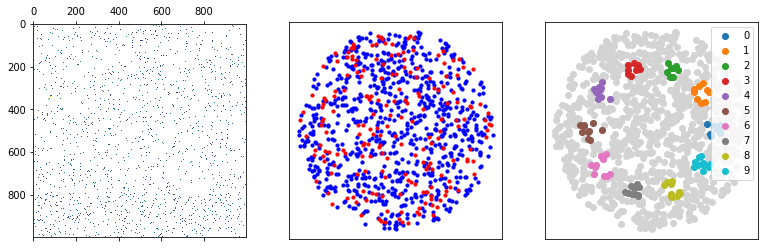

In [14]:
X, Y, W, D = create_weights(params, rng)
Xstim, Ystim = create_stimulus_locations(params)

fig, axs = plt.subplots(ncols=3, figsize=(13,4))
axs[0].matshow(W)
axs[1].scatter(X[:params['N_exc']], Y[:params['N_exc']], s=10, c='b')
axs[1].scatter(X[params['N_exc']:], Y[params['N_exc']:], s=10, c='r')

idx = get_stimulated(X, Y, Xstim, Ystim, params)
axs[2].scatter(X, Y, c='lightgrey')
for i, row in enumerate(idx):
    axs[2].scatter(X[row], Y[row], label=i)
axs[2].legend()

for ax in axs[1:]:
    ax.set_xticks([])
    ax.set_yticks([])

In [15]:
Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
Net.run(30*second)

WARNING    OpenMP code is not yet well tested, and may be inaccurate. [brian2.devices.cpp_standalone.device.openmp]


In [16]:
def raster(net):
    fig, ax = plt.subplots(figsize=(20,5))
    offset = 0
    ticks, mticks, labels = [], [], []
    for k in ['Exc', 'Inh']:
        plt.plot(net[f'SM_{k}'].t/second, net[f'SM_{k}'].i + offset, ',k')
        ticks.append(offset)
        mticks.append(offset+net[k].N/2)
        labels.append(k)
        offset += net[k].N
        print(k, len(net[f'SM_{k}'].i)/net.t/net[k].N)
    ticks.append(offset)
    ax.set_yticks(ticks)
    ax.set_yticks(mticks, minor=True)
    ax.set_yticklabels(labels, minor=True)
    ax.set_xlabel('seconds')
    return ax

Exc 250. uHz
Inh 0. Hz


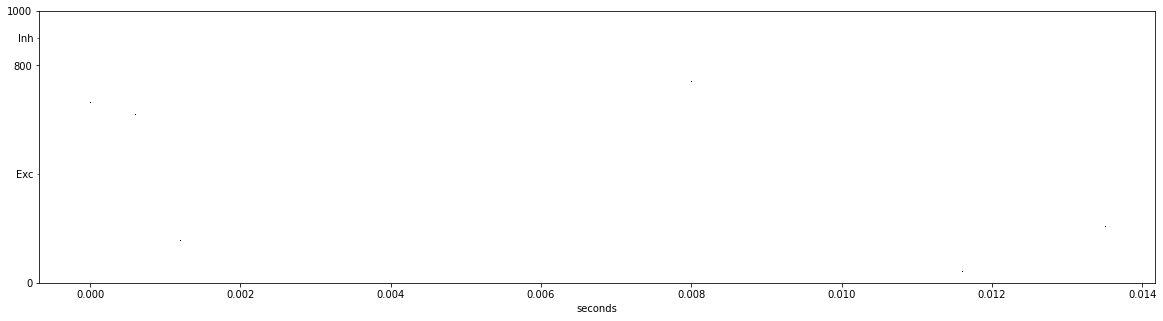

In [17]:
raster(Net);

In [18]:
device.reinit()
device.activate()

In [19]:
def set_input_sequence(Net, sequence, params):
    t = np.arange(len(sequence)) * params['ISI'] + params['settling_period']
    Net['Input'].set_spikes(sequence, t)
    return len(sequence) * params['ISI'] + params['settling_period']

In [20]:
def create_oddball(Net, params, A, B):
    sequence = np.tile([A] * (params['sequence_length']-1) + [B], params['sequence_count'])
    return sequence, set_input_sequence(Net, sequence, params)

In [21]:
def create_MSC(Net, params, rng : np.random.Generator):
    base_sequence = np.arange(params['N_stimuli'])
    rng.shuffle(base_sequence)
    sequence = np.tile(base_sequence, params['sequence_count'])
    return sequence, set_input_sequence(Net, sequence, params)

In [22]:
def get_pulse_spike_counts_TMP(t, ISI):
    pulse_number = t // ISI
    steps = np.flatnonzero(np.diff(pulse_number) > 0)
    internal_num_spikes = np.diff(steps)
    num_spikes = np.concatenate([[steps[0]+1], internal_num_spikes, [0]])
    num_spikes[-1] = len(t) - np.sum(num_spikes)
    return num_spikes

In [23]:
def get_pulse_spike_counts(Net, params):
    offset = 0
    num_spikes = 0
    for k in ['Exc', 'Inh']:
        t, i = Net[f'SM_{k}'].t, Net[f'SM_{k}'].i + offset
        offset += Net[k].N
        mask = t > params['settling_period']
        n = get_pulse_spike_counts_TMP(t[mask] - params['settling_period'], params['ISI'])
        num_spikes += n
    return num_spikes

In [24]:
Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
A, B = 0, 5
Astd = {}
Astd['Seq'], T = create_oddball(Net, params, A, B)
Net.run(T)

Exc 82.45098039 mHz
Inh 77.15686275 mHz
Exc 82.45098039 mHz
Inh 77.15686275 mHz


(26.0, 28.5)

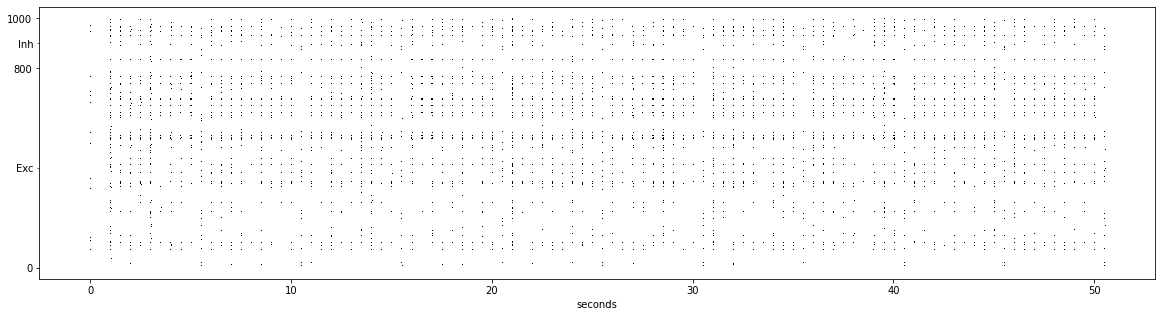

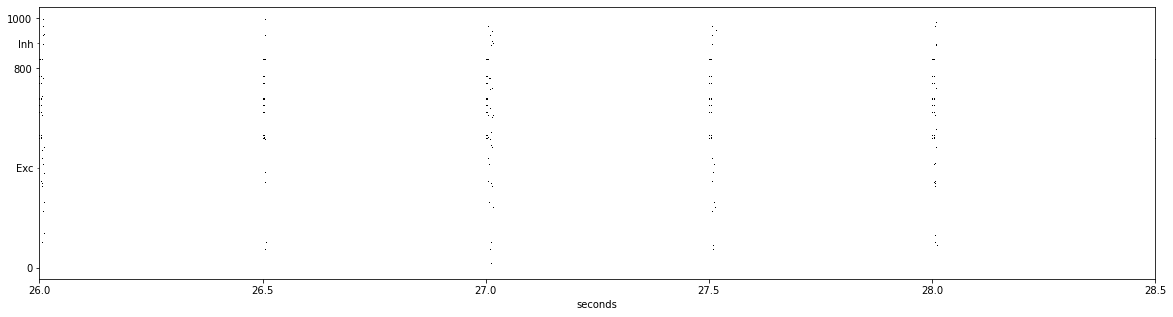

In [25]:
raster(Net)
raster(Net).set_xlim(50*params['ISI'] + params['settling_period'], 55*params['ISI'] + params['settling_period'])

In [26]:
Astd['nspikes'] = get_pulse_spike_counts(Net, params)

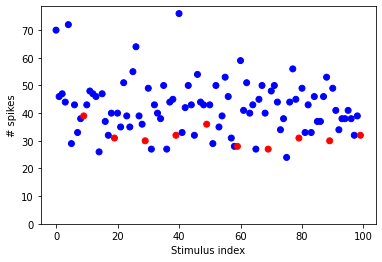

In [27]:
plt.scatter(np.arange(len(Astd['nspikes'])), Astd['nspikes'], c=np.where(Astd['Seq']==A, 'b', 'r'))
plt.ylim(bottom=0)
plt.ylabel('# spikes')
plt.xlabel('Stimulus index');

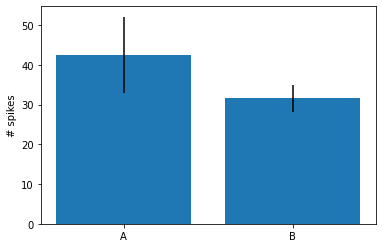

In [28]:
Astd['mean_A'], Astd['std_A'] = np.mean(Astd['nspikes'][Astd['Seq']==A]), np.std(Astd['nspikes'][Astd['Seq']==A])
Astd['mean_B'], Astd['std_B'] = np.mean(Astd['nspikes'][Astd['Seq']==B]), np.std(Astd['nspikes'][Astd['Seq']==B])
plt.bar(['A', 'B'], [Astd['mean_A'], Astd['mean_B']], yerr=[Astd['std_A'], Astd['std_B']])
plt.ylabel('# spikes');

In [29]:
device.reinit()
device.activate()

In [30]:
Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
Bstd = {}
Bstd['Seq'], T = create_oddball(Net, params, B, A)
Net.run(T)

In [31]:
Bstd['nspikes'] = get_pulse_spike_counts(Net, params)

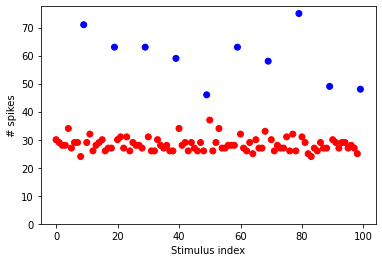

In [32]:
plt.scatter(np.arange(len(Bstd['nspikes'])), Bstd['nspikes'], c=np.where(Bstd['Seq']==A, 'b', 'r'))
plt.ylim(bottom=0)
plt.ylabel('# spikes')
plt.xlabel('Stimulus index');

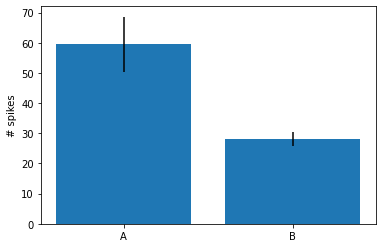

In [33]:
Bstd['mean_A'], Bstd['std_A'] = np.mean(Bstd['nspikes'][Bstd['Seq']==A]), np.std(Bstd['nspikes'][Bstd['Seq']==A])
Bstd['mean_B'], Bstd['std_B'] = np.mean(Bstd['nspikes'][Bstd['Seq']==B]), np.std(Bstd['nspikes'][Bstd['Seq']==B])
plt.bar(['A', 'B'], [Bstd['mean_A'], Bstd['mean_B']], yerr=[Bstd['std_A'], Bstd['std_B']])
plt.ylabel('# spikes');

In [34]:
device.reinit()
device.activate()

In [35]:
Net = create_network(X, Y, Xstim, Ystim, W, D, params, rng)
MSC = {}
MSC['Seq'], T = create_MSC(Net, params, rng)
Net.run(T)

In [36]:
MSC['nspikes'] = get_pulse_spike_counts(Net, params)

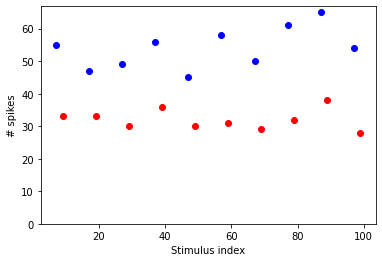

In [37]:
plt.scatter(np.arange(len(MSC['nspikes']))[MSC['Seq']==A], MSC['nspikes'][MSC['Seq']==A], c='b')
plt.scatter(np.arange(len(MSC['nspikes']))[MSC['Seq']==B], MSC['nspikes'][MSC['Seq']==B], c='r')
plt.ylim(bottom=0)
plt.ylabel('# spikes')
plt.xlabel('Stimulus index');

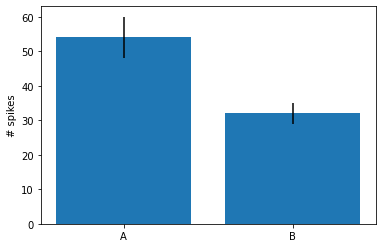

In [38]:
MSC['mean_A'], MSC['std_A'] = np.mean(MSC['nspikes'][MSC['Seq']==A]), np.std(MSC['nspikes'][MSC['Seq']==A])
MSC['mean_B'], MSC['std_B'] = np.mean(MSC['nspikes'][MSC['Seq']==B]), np.std(MSC['nspikes'][MSC['Seq']==B])
plt.bar(['A', 'B'], [MSC['mean_A'], MSC['mean_B']], yerr=[MSC['std_A'], MSC['std_B']])
plt.ylabel('# spikes');

In [39]:
nspikes_std = np.concatenate([Astd['nspikes'][Astd['Seq']==A], Bstd['nspikes'][Bstd['Seq']==B]])
nspikes_dev = np.concatenate([Astd['nspikes'][Astd['Seq']==B], Bstd['nspikes'][Bstd['Seq']==A]])
nspikes_msc = np.concatenate([MSC['nspikes'][MSC['Seq']==A], MSC['nspikes'][MSC['Seq']==B]])
mean_std, stddev_std = nspikes_std.mean(), nspikes_std.std()
mean_dev, stddev_dev = nspikes_dev.mean(), nspikes_dev.std()
mean_msc, stddev_msc = nspikes_msc.mean(), nspikes_msc.std()
contrast_dev_std = (mean_dev - mean_std) / (mean_dev + mean_std)
contrast_dev_msc = (mean_dev - mean_msc) / (mean_dev + mean_msc)
print(f'SSA index: {contrast_dev_std:.3f}\nDD index: {contrast_dev_msc:.3f}')

SSA index: 0.126
DD index: 0.029


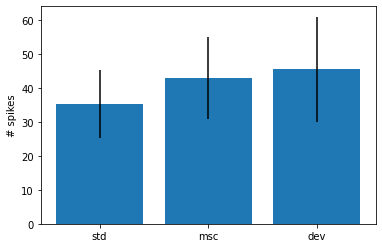

In [40]:
plt.bar(['std', 'msc', 'dev'], [mean_std, mean_msc, mean_dev], yerr=[stddev_std, stddev_msc, stddev_dev])
plt.ylabel('# spikes');

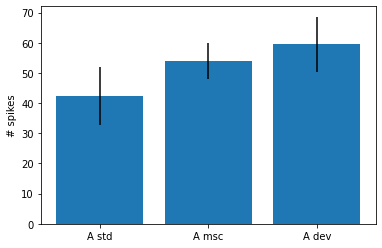

In [41]:
plt.bar(['A std', 'A msc', 'A dev'], [Astd['mean_A'], MSC['mean_A'], Bstd['mean_A']], yerr=[Astd['std_A'], MSC['std_A'], Bstd['std_A']])
plt.ylabel('# spikes');

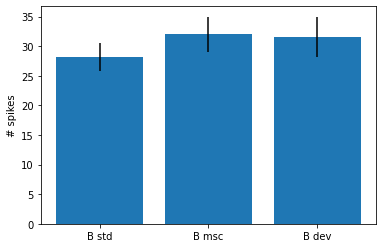

In [42]:
plt.bar(['B std', 'B msc', 'B dev'], [Bstd['mean_B'], MSC['mean_B'], Astd['mean_B']], yerr=[Bstd['std_B'], MSC['std_B'], Astd['std_B']])
plt.ylabel('# spikes');